# EN.535.610 Spring 2023 Project Code

## Authors: Chris Hennessy, Stephen Marinsek, Ryan Payne

## Import the required packages

In [16]:
#Import all required dependencies here

#These dependencies should be available by default via Anaconda install
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

#These dependenies may need to be installed by the user and may not have
#come pre-installed with Anaconda
import xraydb

#Import Matplotlib and configure inline plotting
#Setting up options for plotting
%matplotlib inline
#Settings for jupyter book: svg for html version, high-resolution png for pdf
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'png')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

## Define the required classes for the computation

In [2]:
#Create a class to define internal nodes
#Where x-rays will be absorbed and heat transfer will occur through conduction only
class InternalElement:
    """This class is used by the Section class (via composition design pattern) and represents an internal,
    solid element of material. These elements absorb cold x-rays and transmit heat via conduction only."""
    
    #Class constructor
    def __init__(self,  
                 t_conductivity,
                 specific_heat,
                 cs_area, 
                 ic_temp, 
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density):
        """InternalElement Class Constructor
        This function is used to enter the material properties and initial conditions for each element.
        Inputs:
            t_conductivity <float>: Thermal conductivity of the element's material
            specific_heat <float>: Specific heat of the element's material
            cs_area <float>: The cross-sectional area of the element
            ic_temp <float>: The initial condition for temperature of the element
            element_length <float>: The length of the element (colinear w/ x-ray direction)
            ablation_temp <float>: The temperature at which the material ablates
            rad_abs_coefficient <float>: The mass attenuation factor of the material
            density <float>: The density of the material
        Outputs:
            None"""
        
        #Initialize instance state
        self.absorbed_energy = 0
        self.temp = ic_temp
        self.t_conductivity = t_conductivity
        self.specific_heat = specific_heat
        self.cs_area = cs_area
        self.nm1_temp = 0
        self.nm0_temp = 0
        self.is_ablated = False
        self.element_length = element_length
        self.ablation_temp = ablation_temp
        self.rad_abs_coefficient = rad_abs_coefficient
        self.density = density
        
    #Function to set the initial conditions for the element
    def set_ics(self, initial_temp):
        """This function is used to set the temperature initial condition of the element.
        Inputs:
            initial_temp <float>: The initial condition for temperature of the element
        Outputs:
            None"""
        
        self.nm1_temp = initial_temp

#Create a class to define boundary nodes where no x-rays are absorbed
#and heat transfer will occur to surroundings via radiation
class BoundaryElement:
    
    #Class constructor
    def __init__(self, t_emissivity, cs_area):
        
        #Initialize instance state
        self.t_emissivity = emissivity
        self.cs_area = cs_area
        self.scene_temp = 0
        
    #Function to set the scene temperature
    def set_ics(self, scene_temp):
        
        self.scene_temp = scene_temp
        
#Create a class to define the entire section of material
#The computation will be performed here
class Section:
    
    eV_to_Joule = 1.602e-19
    
    #Class constructor
    def __init__(self):
        self.elements_list = []
        self.rem_elements = []
        self.has_run_rad = False
        self.has_run_ablation = False
        self.has_run_temp = False
        
    #Function to add a material layer to the section
    #Materials added from foreward (x-ray incoming direction) and populates back
    def add_matl(self,
                 quantity,
                 t_conductivity,
                 specific_heat,
                 cs_area,
                 ic_temp,
                 element_length,
                 ablation_temp,
                 rad_abs_coefficient,
                 density):
        
        for i in range(0, quantity):
            new_element = InternalElement(t_conductivity,
                                          specific_heat,
                                          cs_area,
                                          ic_temp,
                                          element_length,
                                          ablation_temp,
                                          rad_abs_coefficient,
                                          density)
            self.elements_list.append(new_element)
        
    #Function to propagate x-rays through material
    def prop_xray_energy(self, tot_x_ray_energy):
    
        tsprt_flux = tot_x_ray_energy
        for element in self.elements_list:
            delta_tsprt_flux = tsprt_flux * element.rad_abs_coefficient * element.density * element.element_length
            element.absorbed_energy += delta_tsprt_flux
            tsprt_flux = tsprt_flux - delta_tsprt_flux
            
        for element in self.elements_list:
            energy_joules = element.absorbed_energy*Section.eV_to_Joule
            volume = element.cs_area * element.element_length
            element.temp = energy_joules / (volume*element.specific_heat) + element.temp
    
    #Function to get the total absorbed x-ray energy for each element
    def get_absorbed_energy(self):
        absorbed_energy_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                absorbed_energy_list.append(element.absorbed_energy)
        
        print(len(absorbed_energy_list))
        return absorbed_energy_list
    
    #Function to get the temperature distribution for each element
    def get_temperatures(self):
        temp_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                temp_list.append(element.temp)
                
        return temp_list
    
    #Function to get a list of the distances of each node from the outermost surface
    def get_node_distances(self):
        dist_list = []
        dist = 0
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                dist_list.append(dist)
                dist += element.element_length
                
        return dist_list
    
    #Function to get a list of mass attenuation factors for each element
    def get_macs(self):
        mac_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                mac_list.append(element.rad_abs_coefficient)
                
        return mac_list
    
    #Function to get a list of densities for each element
    def get_densities(self):
        density_list = []
        for element in self.elements_list:
            if isinstance(element, InternalElement):
                density_list.append(element.density)
                
        return density_list
    
    #Function to evaluate ablation
    def eval_ablation(self):
        
        for element in elements_list:
            if (element.nm0_temp >= element.ablation_temp):
                element.is_ablated = True
    
    #Function to initialize for transient thermal problem
    def init_transient_thermal(self, front_bc_ele, back_bc_ele):
        
        rem_elements = []
        rem_elements.append(front_bc_ele)
        for element in elements_list:
            if element.is_ablated == False:
                rem_elements.append(element)
        rem_elements.append(back_bc_ele)
    
    #Function to iterate through time for transient thermal analyses
    #def eval_transient_thermal(self, interations):
    
    #Functions to return results

## Analysis Section

### Define the Cold X-Ray Profile from Literature

In [3]:
#Define the cold x-ray profile outlined in M.S. Smith et al
#Corresponds to a 1.5M Ton Device at 10 km distance
i_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
i_energy = 13.5e3 #[eV], Average energy of x-rays from event

### Use XrayDB Library to Pull Mass Attenuation Coefficients

Units are converted to m, kg, s for consistency

In [4]:
al_mac = xraydb.mu_elam('Al', i_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]
print('Aluminum Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(al_mac))

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]
print('Aluminum Density: {0:.1f} [kg/m^3]'.format(al_dens))

carb_mac = xraydb.mu_elam('C', i_energy) #[cm^2/g]
carb_mac = carb_mac / 10 #[m^2/kg]
print('Carbon Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(carb_mac))

carb_dens = xraydb.atomic_density('C') #[g/cm^3]
carb_dens = carb_dens * 1000 #[kg/m^3]
print('Carbon Density: {0:.1f} [kg/m^3]'.format(carb_dens))

Aluminum Mass Attenuation Coefficient: 1.08 [m^2/kg]
Aluminum Density: 2700.0 [kg/m^3]
Carbon Mass Attenuation Coefficient: 0.10 [m^2/kg]
Carbon Density: 2267.0 [kg/m^3]


## Perform X-ray Propagation Step

# Verification, Validation, and Error Section

## Evaluate Error of Numerical Solution Against Analytical for Absorbed X-rays

Since x-ray absorption for a monolithic material is the solution to a 1-dimensional ODE, we can directly compare numerical and analytical solutions for simple cases.

To verify, we analyze a single cross section of aluminum using the numerical method in our package and compare to the accepted analytical solution of the following form:

[TODO Insert Equation]

For this comparison, we use a 1 mm thick section of aluminum with 1000 elements. Small element sizes are required because large amounts of energy are absorbed near the surface which can cause numerical instability if gradients are too steep and elements are too large.

Aluminum Mass Attenuation Coefficient: 1.08 [m^2/kg]
Aluminum Density: 2700.0 [kg/m^3]
1000
Absolute error between analytical solution and numerical solution: 7353268357194787586048.00 [eV]


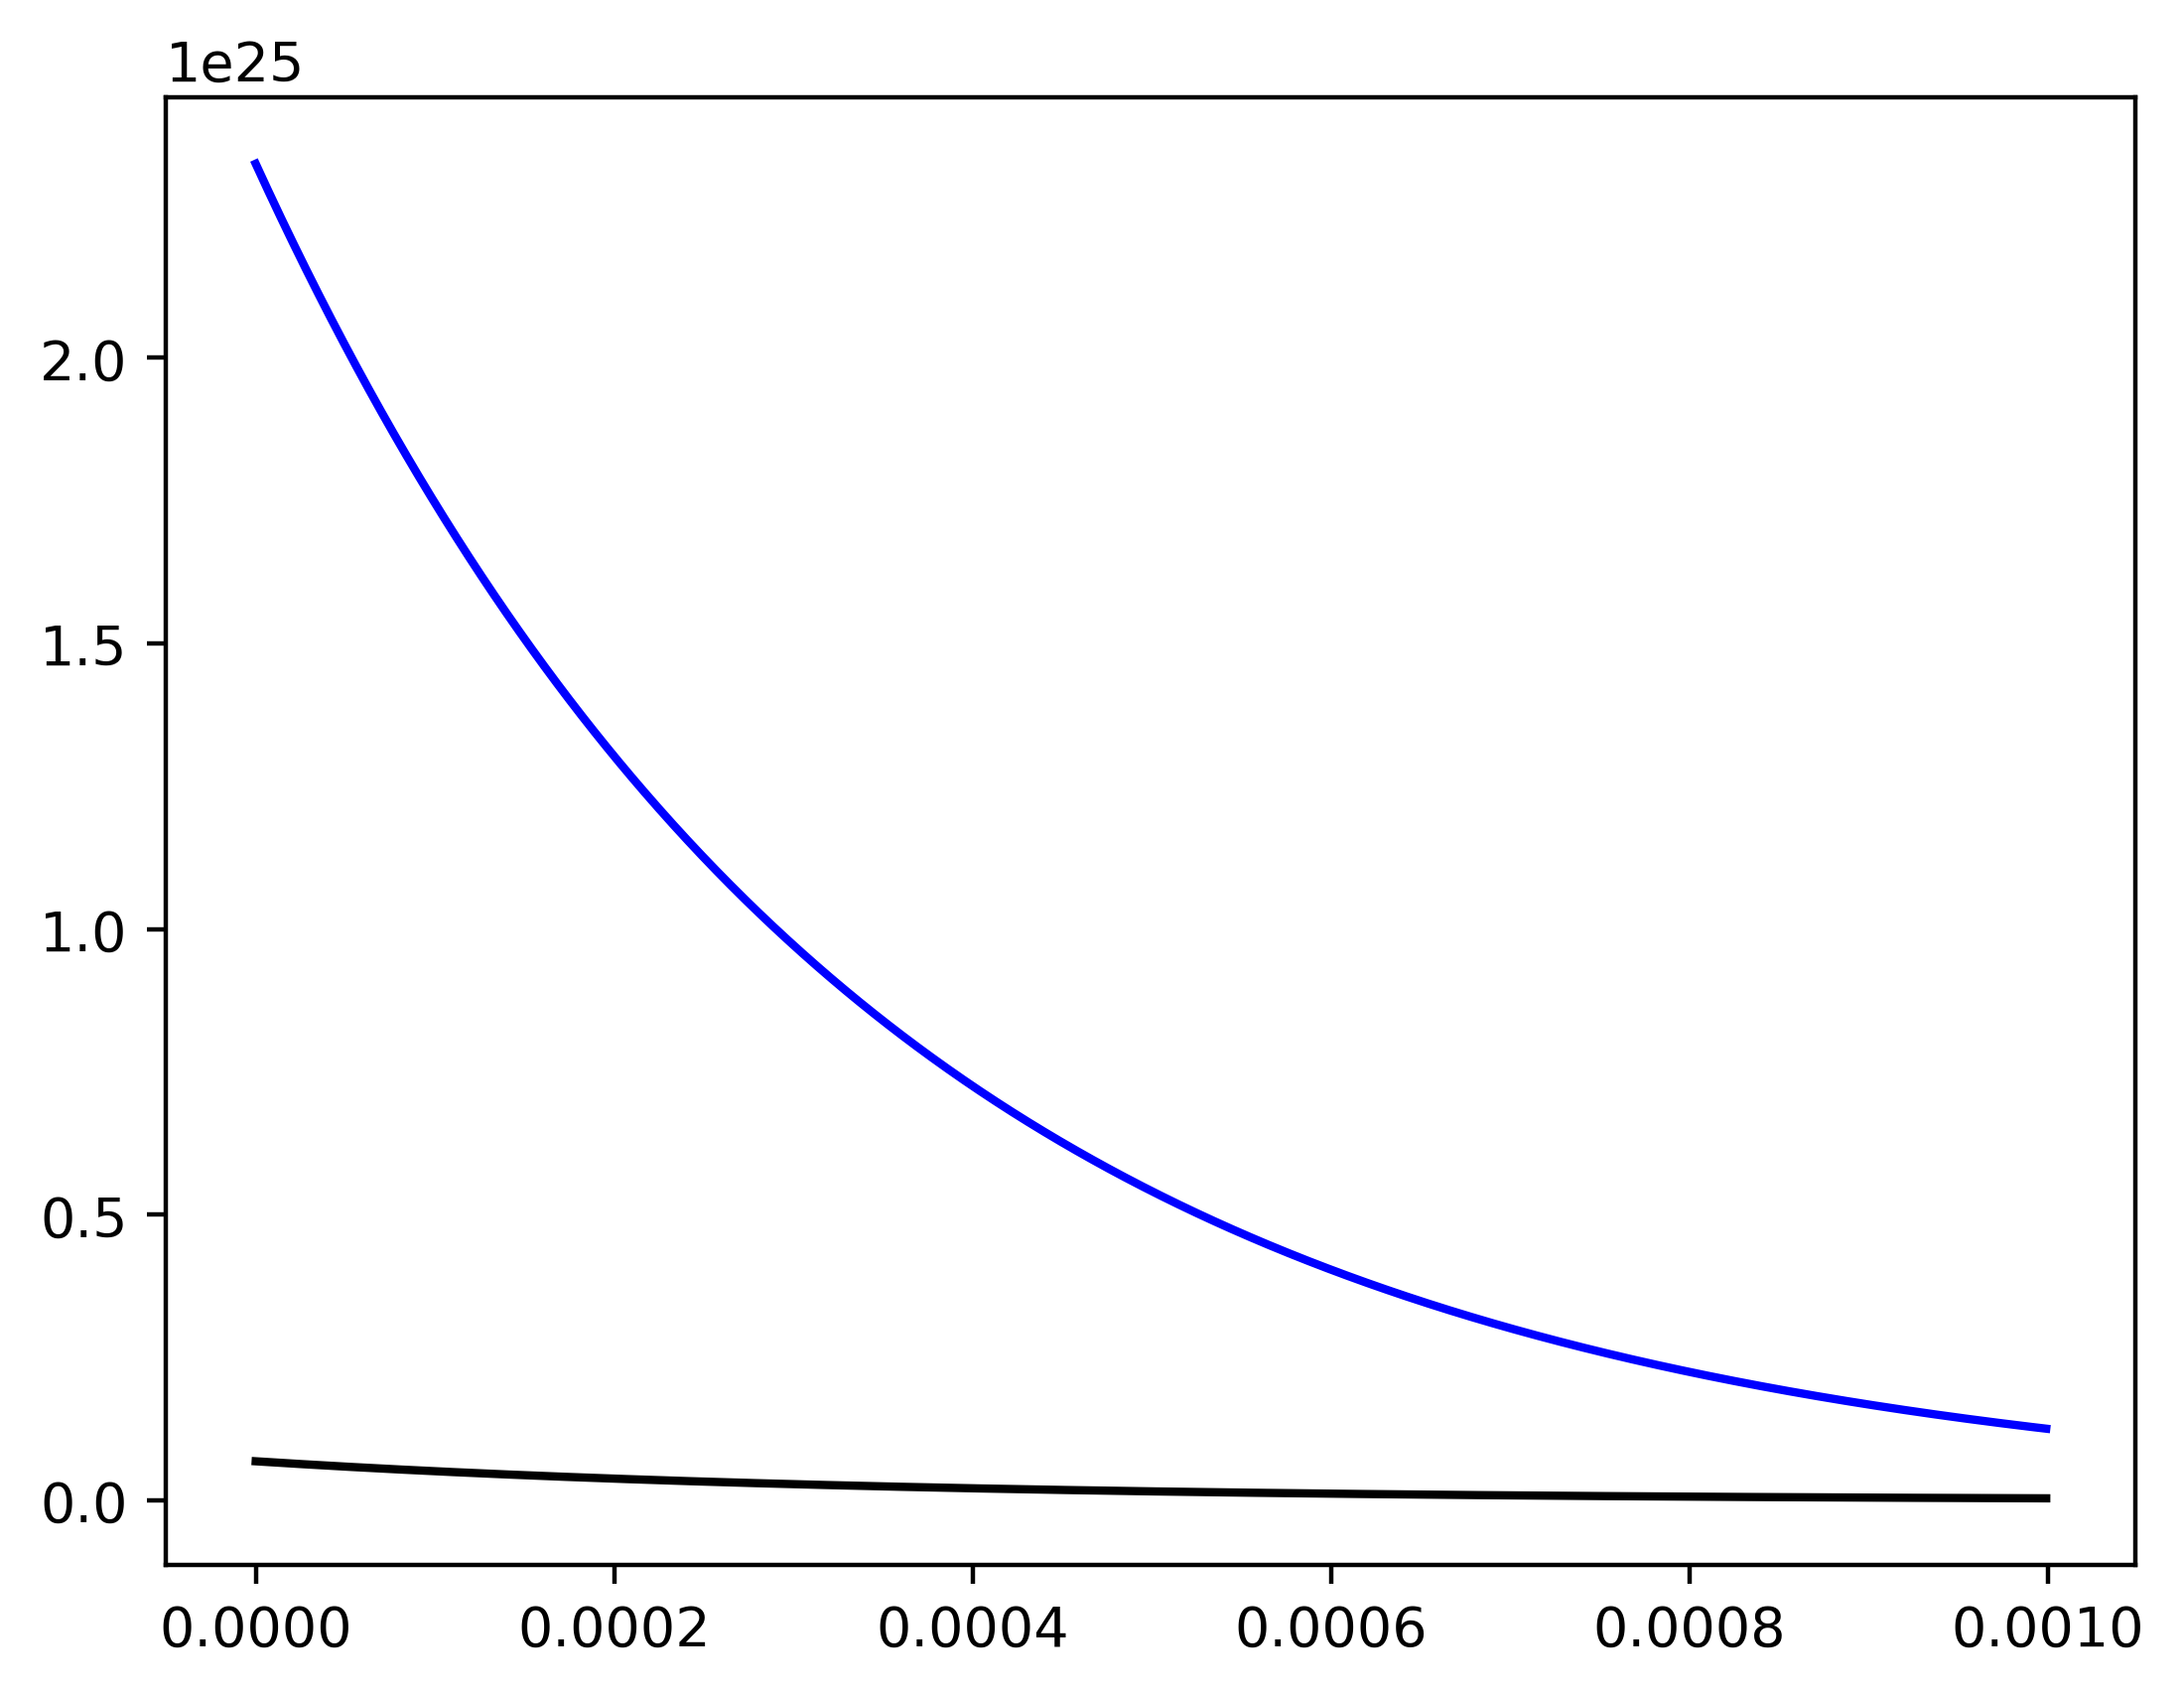

In [22]:
#Pull material data for aluminum
al_mac = xraydb.mu_elam('Al', i_energy) #[cm^2/g]
al_mac = al_mac / 10 #[m^2/kg]
print('Aluminum Mass Attenuation Coefficient: {0:.2f} [m^2/kg]'.format(al_mac))

al_dens = xraydb.atomic_density('Al') #[g/cm^3]
al_dens = al_dens * 1000 #[kg/m^3]
print('Aluminum Density: {0:.1f} [kg/m^3]'.format(al_dens))

#Configure section of material
elements = 1000 #[-]
e_thickness = 0.000001 #[m]
al_k = 237 #[W/m*k] - not used for this verification
e_area = 0.1 #[m^2] - not used for this verification
ic_temp = 293.0 #[K] - not used for this verification
al_ab_temp = 1000.0 #[K] - placeholder, not used for this verification
al_c = 897.0 #[J/kg*C] - not used for this verification
v_section = Section()
v_section.add_matl(quantity=elements,
                   t_conductivity=al_k,
                   specific_heat=al_c,
                   cs_area=e_area,
                   ic_temp=ic_temp,
                   element_length=e_thickness,
                   ablation_temp=al_ab_temp,
                   rad_abs_coefficient=al_mac,
                   density=al_dens)

#Configure x-ray profile
v_flux = 1.7332e21 #[Total x-rays], Total x-rays from event
v_energy = 13.5e3 #[eV], Average energy of x-rays from event

#Propagate x-rays through material
check_section.prop_xray_energy(v_flux*v_energy)
abs_energy = check_section.get_absorbed_energy()

#Solve the same problem using the analytical solution
def analytical_soln(I0, mac, density, depth):
    return I0 * math.exp(-mac * density * depth)

#Estimate the error by integrating the absolute value of the difference between the two solutions at
#each point.
abs_error = 0
analytical_values = []
depth_list = v_section.get_node_distances()
for i in range(0, elements):
    analytical_value = analytical_soln(v_flux*v_energy, al_mac, al_dens, depth_list[i])
    analytical_values.append(analytical_value)
    abs_error += abs(analytical_value - abs_energy[i]) * e_thickness
print("Absolute error between analytical solution and numerical solution: {0:.2f} [eV]".format(abs_error))
    
#Visualize the results
fig, ax = plt.subplots()
ax.plot(depth_list, analytical_values, 'b')
ax.plot(depth_list, abs_energy, 'k')
plt.show()

### Testing Section

1000


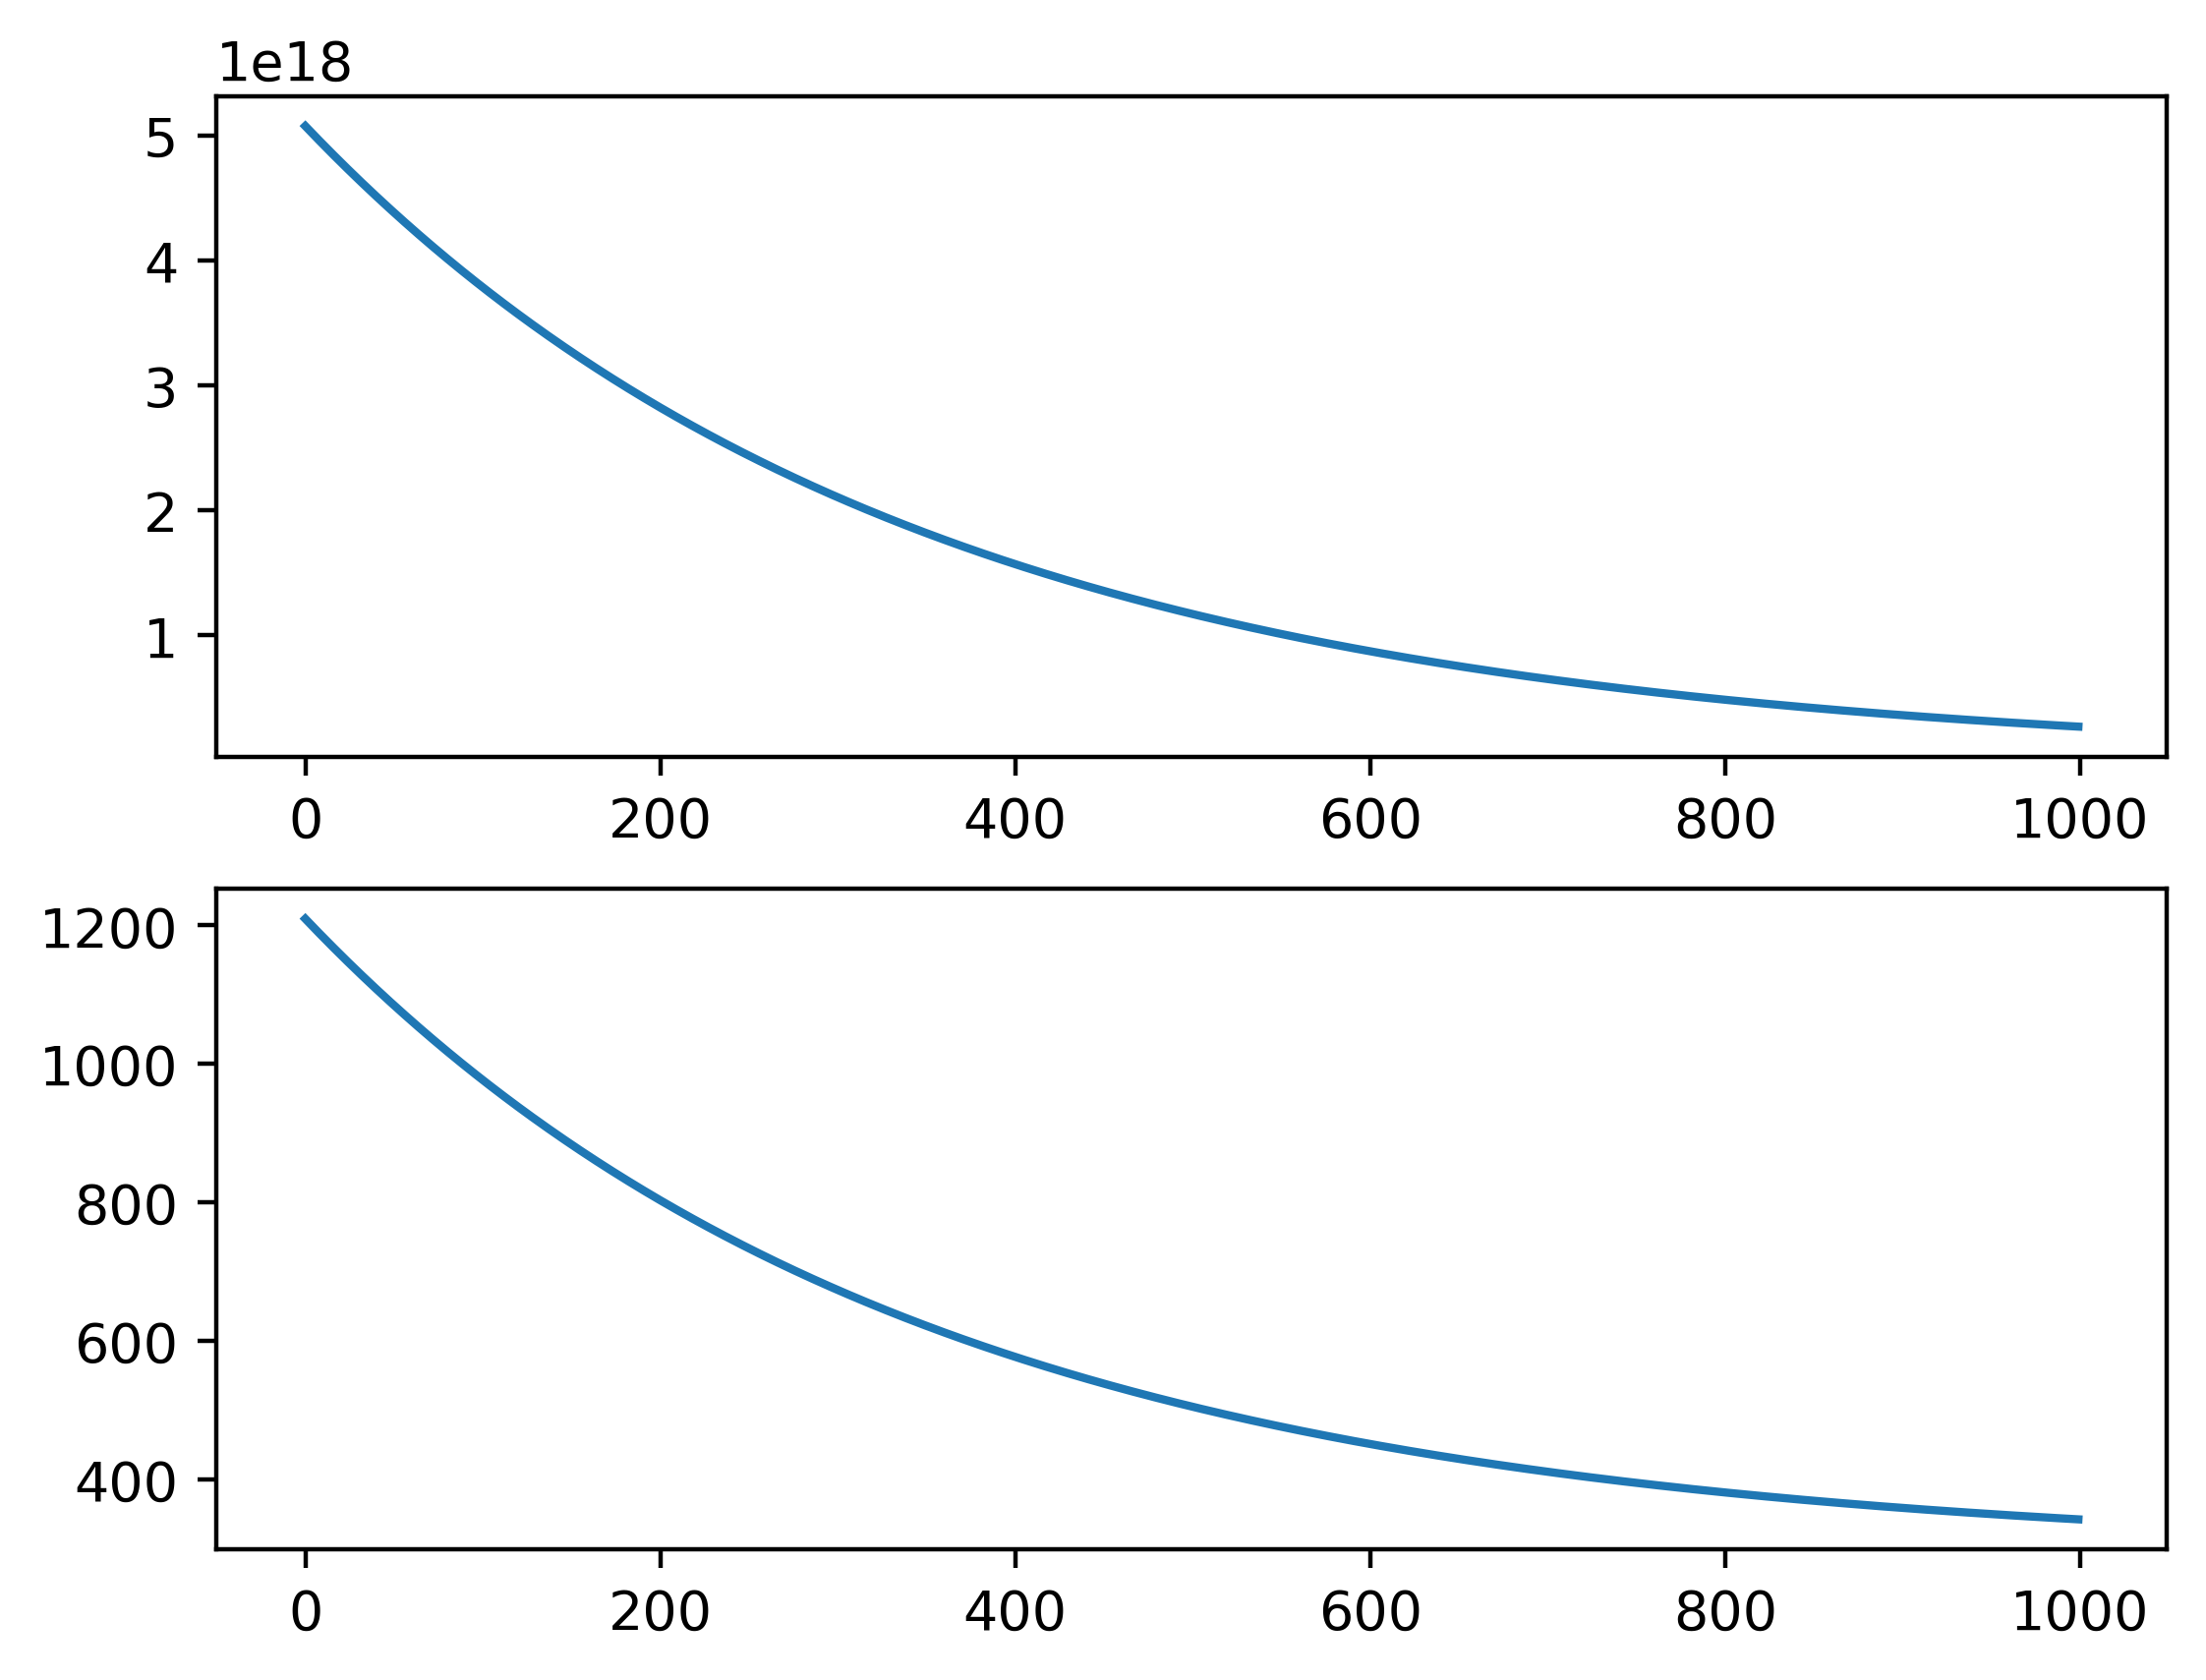

In [5]:
test_xray_energy = i_flux
t_conductivity = 1.0
specific_heat = 887
cs_area = 1.0
ic_temp = 293.0
ablation_temp = 100.0

test_section = Section()
test_section.add_matl(1000,
                      t_conductivity,
                      specific_heat,
                      cs_area,
                      ic_temp,
                      0.000001,
                      ablation_temp,
                      al_mac,
                      al_dens)

test_section.prop_xray_energy(test_xray_energy)
a_energy = test_section.get_absorbed_energy()
temp = test_section.get_temperatures()

fig, ax = plt.subplots(2)
x_points = range(0, len(a_energy))
ax[0].plot(x_points, a_energy)
ax[1].plot(x_points, temp)
plt.show()